In [1]:
import os
import json
import re
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
cfg = {
    'train_path': '/kaggle/input/contract-nli-dataset/train.json',
    'test_path': '/kaggle/input/contract-nli-dataset/test.json'
}


In [3]:
def load_data(path: str) -> dict:
    with open(path, 'r') as f:
        return json.load(f)

In [4]:
def get_labels() -> dict:
    return {
        'NotMentioned': 0,
        'Entailment': 1,
        'Contradiction': 2,
    }

In [5]:
def get_hypotheses(data: dict) -> dict:
    return {key: clean_text(value['hypothesis']) for key, value in data['labels'].items()}


In [6]:
def clean_text(text: str) -> str:
    text = text.replace('\n', ' ')
    text = re.sub(r'\\t|\\r', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    return ' '.join(word_tokenize(text.strip().lower()))


In [7]:
def clean_data(data: dict) -> None:
    for doc in data['documents']:
        doc['text'] = clean_text(doc['text'])

In [8]:
# Vectorize and prepare training/testing data
def prepare_features(data: dict, tfidf: TfidfVectorizer, hypotheses: dict, labels: dict):
    X, Y = [], []
    for doc in data["documents"]:
        premise_vector = tfidf.transform([doc["text"]])
        for key, hyp_text in hypotheses.items():
            hypothesis_vector = tfidf.transform([hyp_text])
            combined_vector = sp.hstack([premise_vector, hypothesis_vector])
            X.append(combined_vector)
            Y.append(labels[doc["annotation_sets"][0]["annotations"][key]["choice"]])
    return sp.vstack(X), Y

In [9]:
train_data = load_data(cfg['train_path'])
clean_data(train_data)
hypotheses = get_hypotheses(train_data)
labels = get_labels()

In [10]:
all_text = " ".join([doc["text"] for doc in train_data["documents"]])
tfidf = TfidfVectorizer().fit([all_text])

In [11]:
X_train, Y_train = prepare_features(train_data, tfidf, hypotheses, labels)

In [12]:
model = SVC(kernel='linear')
model.fit(X_train, Y_train)

SVC(kernel='linear')

In [13]:
test_data = load_data(cfg['test_path'])
clean_data(test_data)
X_test, Y_test = prepare_features(test_data, tfidf, hypotheses, labels)

In [14]:
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.6815


In [15]:
report = classification_report(Y_test, Y_pred, target_names=labels.keys())
print("Classification Report:\n", report)

Classification Report:
                precision    recall  f1-score   support

 NotMentioned       0.70      0.62      0.66       903
   Entailment       0.72      0.77      0.74       968
Contradiction       0.48      0.54      0.51       220

     accuracy                           0.68      2091
    macro avg       0.63      0.64      0.64      2091
 weighted avg       0.68      0.68      0.68      2091



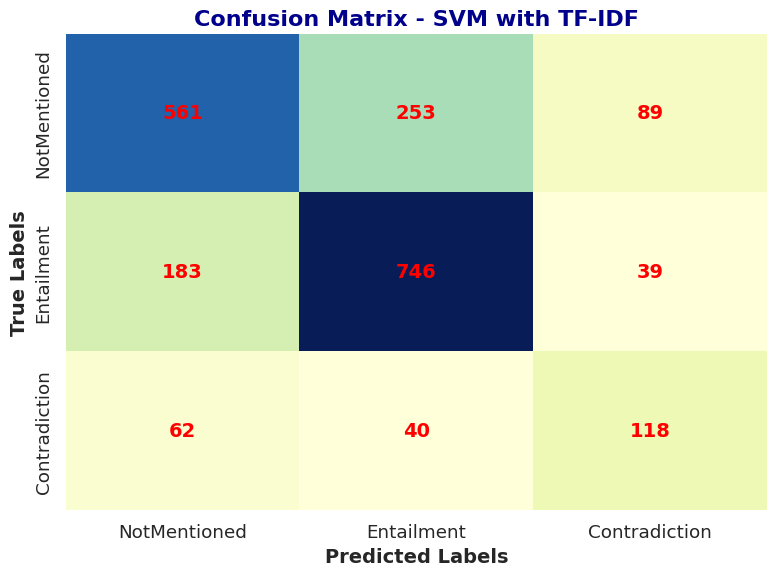

In [16]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
    xticklabels=labels.keys(), yticklabels=labels.keys(),
    annot_kws={"size": 14, "weight": "bold", "color": "red"}
)
plt.xlabel('Predicted Labels', fontsize=14, weight='bold')
plt.ylabel('True Labels', fontsize=14, weight='bold')
plt.title('Confusion Matrix - SVM with TF-IDF', fontsize=16, weight='bold', color='darkblue')
plt.tight_layout()
plt.show()
